## TensorFlow

In [1]:

import cv2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics


import datetime, os
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")



#### Configuración dataset:
Definimos algunos parámetro importantes como: tamaño de imagenes, número de clases, etiquetas de las clases, número de epocas, batch size. Finalmente configuramos el dataset


[Dataset Kaggle](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset)


In [2]:
# Definimos las rutas del dataset 
train_data_dir = './data/images/train'
val_data_dir = './data/images/validation'

In [3]:


# Definimos algunos parámetros importantes
width_shape = 48 # Ancho tamaño de las imagenes
height_shape = 48 # Alto tamaño de las imagenes  
num_classes = 7 # Número de emociones 
epochs = 100 # El numero de veces que itera 
batch_size = 32 # Número de imágenes por lote en cada actualización del modelo
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise'] # El nombre de las clases en este caso emociones.

# Configuramos el dataset de entrenamiento y validación
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(  
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Modelo CNN:
Definimos la arquitectura del modelo CNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()

# Bloques de convolución mejorados
model.add(Conv2D(32, (7,7), padding='same', input_shape=(width_shape, height_shape, 1), kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Clasificación
model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Compilación con Scheduler
opt = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callback para reducir LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,575 (4.87 MB)

 Trainable params: 1,276,615 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

### Configuración TensorBoard

In [6]:
# Configuración Tensorboard para ver las curvas de entrenamiento. 

%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

### Entrenamiento

In [7]:

model.fit(  
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_steps=val_generator.n//batch_size,
    callbacks=[tensorboard_callback])

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.2118 - loss: 2.3010 - val_accuracy: 0.3456 - val_loss: 1.7438
Epoch 2/100
  1/900 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.4375 - loss: 1.7794

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 1.7794 - val_accuracy: 0.3462 - val_loss: 1.7415
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.2951 - loss: 1.9591 - val_accuracy: 0.3815 - val_loss: 1.7024
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3438 - loss: 1.8455 - val_accuracy: 0.3803 - val_loss: 1.7072
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.3330 - loss: 1.8222 - val_accuracy: 0.4037 - val_loss: 1.6416
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3125 - loss: 1.7357 - val_accuracy: 0.4040 - val_loss: 1.6410
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.3641 - loss: 1.7163 - val_accuracy: 0.4190 - val_loss: 1.5731
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 1.5199 - val_accuracy: 0.4207 - val_loss: 1.5694
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.3852 - loss: 1.6637 - val_accuracy

In [8]:
#salvar el modelo como h5 
model.save('modelFEC.h5')

In [9]:
#salvar el modelo como keras
model.save("modelFEC.h52.keras")

### Pruebas y validacion 

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.metrics_names)  # Esto estará vacío hasta entrenar/evaluar


['loss', 'compile_metrics']


### Matrix de confusion y metricas 

Found 7066 images belonging to 7 classes.
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0     0.5768    0.4188    0.4852       960
           1     0.7662    0.5315    0.6277       111
           2     0.5066    0.3762    0.4318      1018
           3     0.7946    0.8351    0.8143      1825
           4     0.5210    0.6316    0.5710      1216
           5     0.4551    0.5338    0.4913      1139
           6     0.7413    0.7516    0.7464       797

    accuracy                         0.6146      7066
   macro avg     0.6231    0.5826    0.5954      7066
weighted avg     0.6152    0.6146    0.6100      7066



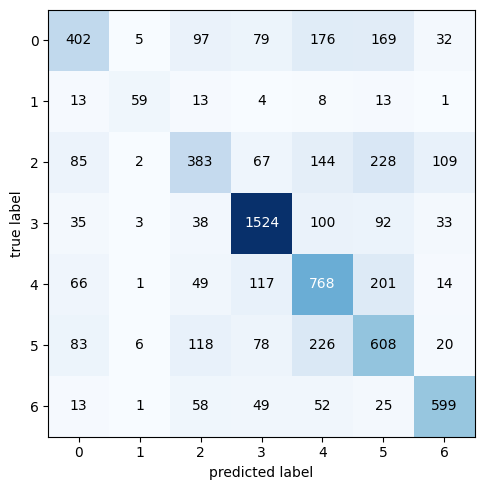

In [12]:


# Configuración del dataset de validación sin shuffle
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(  
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=False)

predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = val_generator.classes

matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))